This notebook reads the recalibration results and plot the CER and WER curves.
Make sure you run `run_no_recalibration.sh` and `run_recalibration.sh` first.
Note that only recalibration blocks are used in this notebook.
Therefore the curve looks different from the paper.

In [9]:
import os
import pickle
import numpy as np

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

from omegaconf import OmegaConf
from edit_distance import SequenceMatcher
import matplotlib.pyplot as plt


def smooth(x,window_len=11,window='flat'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

def get_state(exp_dirs):
    out = []

    for exp_dir in exp_dirs:
        try:
            config = OmegaConf.load(os.path.join(exp_dir, 'args.yaml'))
            with open(os.path.join(exp_dir, 'state.pkl'), 'rb') as f:
                state = pickle.load(f)
                refs = state['sentence']
                hyps_raw = state['decoded']
                hyps_lm = state['pseudo_label']
                if len(hyps_lm) == 0:
                    hyps_lm = state['lm_decoded']

                total_edist_raw = 0
                total_edist_psd = 0
                total_len = 0
                for i, ref in enumerate(refs):
                    matcher = SequenceMatcher(a=ref, b=hyps_raw[i])
                    total_edist_raw += matcher.distance()
                    matcher = SequenceMatcher(a=ref, b=hyps_lm[i])
                    total_edist_psd += matcher.distance()
                    total_len += len(ref)

            out.append((exp_dir, config, total_edist_raw / total_len, total_edist_psd / total_len, state))
        except Exception as e:
            print(exp_dir)
            print(e)

    return out

In [12]:
# Change the following directories to your own

exp_out = get_state([
    '/oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_no_recal_release',
    '/oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_recal_release'
])

/tmp/ipykernel_54134/1050694375.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([int(x) for x in axs[0].get_xticks()], fontsize=14)
/tmp/ipykernel_54134/1050694375.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([f'{int(x*100)}' for x in axs[0].get_yticks()], fontsize=14)
/tmp/ipykernel_54134/1050694375.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([int(x) for x in axs[1].get_xticks()], fontsize=14)
/tmp/ipykernel_54134/1050694375.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([f'{int(x*100)}' for x in axs[1].get_yticks()], fontsize=14)


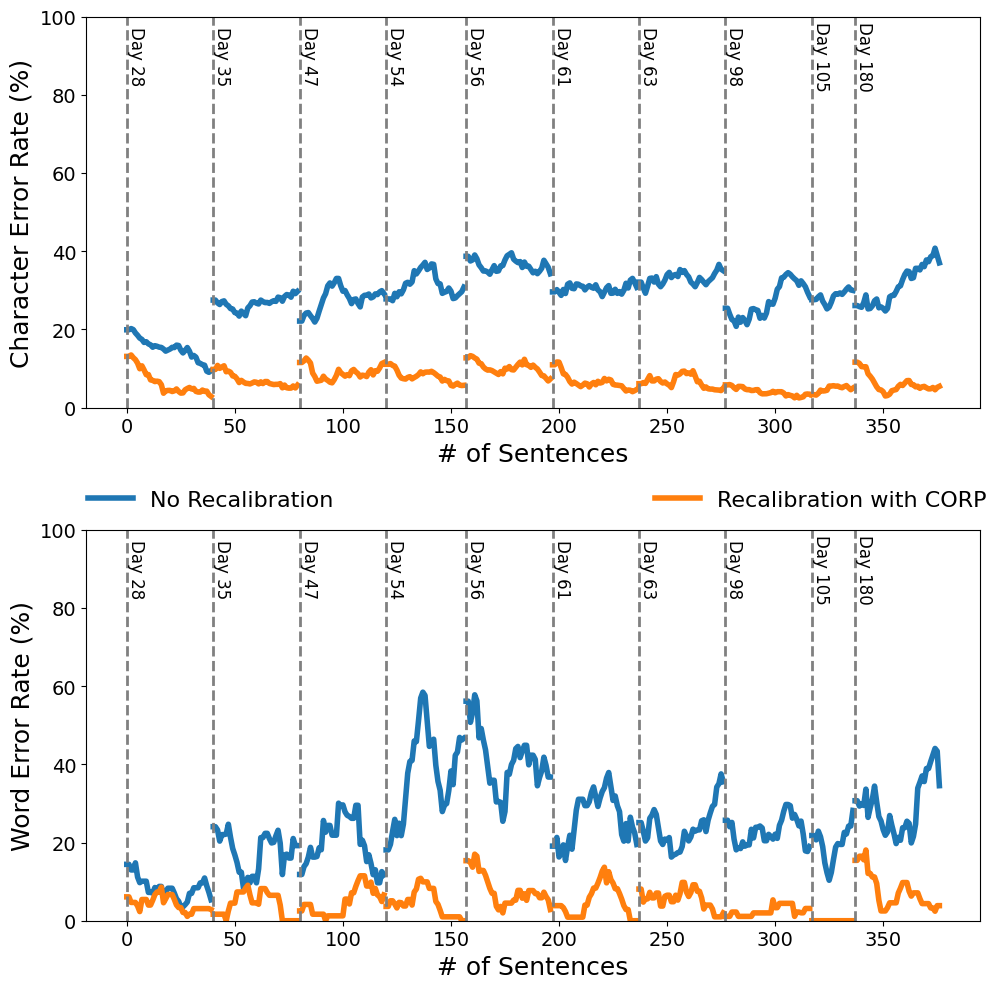

In [13]:
def get_xs_ys(error_rates):
    xs = []
    ys = []
    for i, ers in enumerate(error_rates):
        ers = smooth(np.array(ers), window_len=10)
        for j, cer in enumerate(ers):
            xs.append(session_start_idx[i] + j)
            ys.append(cer)
        xs.append(session_start_idx[i] + len(ers))
        ys.append(np.nan)
    return xs, ys


fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# No recalibration
state = exp_out[0][4]
sessions = state['session']
session_start_idx = [0] + [i + 1 for i, (cur, next) in enumerate(zip(sessions[:], sessions[1:])) if cur != next] + [len(sessions)]

session_cers = []
session_wers = []
for start, end in zip(session_start_idx[:], session_start_idx[1:]):
    session_cers.append(state['cer'][start:end])
    session_wers.append(state['lm_wer'][start:end])


axs[0].plot(*get_xs_ys(session_cers), linewidth=4)
axs[1].plot(*get_xs_ys(session_wers), linewidth=4)

# CORP recalibration
state = exp_out[1][4]
session_cers = []
session_wers = []
for start, end in zip(session_start_idx[:], session_start_idx[1:]):
    session_cers.append(state['cer'][start:end])
    session_wers.append(state['lm_wer'][start:end])

axs[0].plot(*get_xs_ys(session_cers), linewidth=4)
axs[1].plot(*get_xs_ys(session_wers), linewidth=4)

axs[0].set_xticklabels([int(x) for x in axs[0].get_xticks()], fontsize=14) 
axs[0].set_ylim([0.0, 1.0])
axs[0].set_yticklabels([f'{int(x*100)}' for x in axs[0].get_yticks()], fontsize=14) 
axs[0].set_xlabel('# of Sentences', fontsize=18)
axs[0].set_ylabel('Character Error Rate (%)', fontsize=18)

axs[1].set_xticklabels([int(x) for x in axs[1].get_xticks()], fontsize=14) 
axs[1].set_ylim([0.0, 1.0])
axs[1].set_yticklabels([f'{int(x*100)}' for x in axs[1].get_yticks()], fontsize=14) 
axs[1].set_xlabel('# of Sentences', fontsize=18)
axs[1].set_ylabel('Word Error Rate (%)', fontsize=18)


# Vertical lines
xs = session_start_idx
days = [28, 35, 47, 54, 56, 61, 63, 98, 105, 180, 228, 272, 300, 349, 403]
for i , (x, d) in enumerate(zip(xs[:-1], days)):
    axs[0].axvline(x=x, color='gray', ls='--', linewidth=2)
    axs[0].text(x, 0.9, "Day %d" % d, rotation=-90, verticalalignment='center', fontsize=12)

days = [28, 35, 47, 54, 56, 61, 63, 98, 105, 180, 228, 272, 300, 349, 403]
for i , (x, d) in enumerate(zip(xs[:-1], days)):
    axs[1].axvline(x=x, color='gray', ls='--', linewidth=2)
    axs[1].text(x, 0.9, "Day %d" % d, rotation=-90, verticalalignment='center', fontsize=12)


plt.legend(labels=['No Recalibration', 'Recalibration with CORP'], loc='lower left', mode='expand', ncol=2,
           bbox_to_anchor=(-0.02, 1.0, 1.05, 0.), frameon=False, fontsize=16)

plt.tight_layout()
plt.show()